In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor

from treemind.algorithm import Explainer
from treemind.plot import interaction_scatter_plot

import seaborn as sns
import matplotlib.pyplot as plt
import shap

from typing import Tuple

from matplotlib.colors import TwoSlopeNorm

In [2]:
def feature_plot(
    df: pd.DataFrame,
    col_max,
    col_min,
    figsize: Tuple[int, int] = (10, 6),
    show_min_max: bool = False,
    title_fontsize: float = 16.0,
    label_fontsizes: float = 14.0,
    title: str | None = None,
    xlabel: str | None = None,
    ylabel: str | None = None,
) -> None:
    """
    Plots the mean, min, and max values of a feature based on tree split points.

    This method takes as input the output DataFrame from the `analyze_feature`
    method of the `treemind.Explainer` class (`analyze_feature(self, col: int) -> pd.DataFrame`).

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the feature data with the following columns:
        - 'feature_lb': Lower bound of the feature range (tree split point).
        - 'feature_ub': Upper bound of the feature range (tree split point).
        - 'mean': Mean value of the feature within this range.
        - 'min': Minimum value of the feature within this range.
        - 'max': Maximum value of the feature within this range.
    figsize : tuple of int, optional, default (10.0, 6.0)
        Width and height of the plot in inches.
    show_min_max : bool, optional, default False
        If True, shaded areas representing the min and max values will be displayed.
    xticks_n : int, optional, default 10
        Number of tick marks to display on the x-axis.
    yticks_n : int, optional, default 10
        Number of tick marks to display on the y-axis.
    ticks_decimal : int, optional, default 3
        Number of decimal places for tick labels
    ticks_fontsize : float, optional, default 10.0
        Font size for axis tick labels,
    title_fontsize : float, optional, default 16.0
        Font size for the plot title.
    title : str, optional, default None
        The title displayed at the top of the plot. If `None`, no title is shown.
    xlabel : str, optional, default None
        Label for the x-axis. If None, it will default to the feature name.
    ylabel : str, optional, default None
        Label for the y-axis. Defaults to "Value" if not specified.

    Returns
    -------
    None
        Displays the plot.
    """

    # Validate parameters

    column_name = df.columns[1]

    df.loc[np.isposinf(df[column_name]), column_name] = col_max

    # Set default labels if None
    xlabel = xlabel if xlabel is not None else column_name[:-3]
    ylabel = ylabel if ylabel is not None else "Value"

    extend_ratio = 0.05 * (df[column_name].max() - df[column_name].min())

    min_row = df.iloc[df[column_name].argmin()].copy()
    min_row[column_name] = col_min

    max_row = df.iloc[df[column_name].argmax()].copy()
    max_row[column_name] += extend_ratio

    df = pd.concat([min_row.to_frame().T, df], ignore_index=True)

    plt.figure(figsize=figsize)

    sns.lineplot(
        data=df,
        x=column_name,
        y="mean",
        color="blue",
        linewidth=2,
        drawstyle="steps-pre",
    )

    if show_min_max:
        plt.fill_between(
            df[column_name],
            df["min"],
            df["max"],
            color="gray",
            alpha=0.3,
            label="Min-Max Range",
            step="post",
        )

    # Set the plot title
    if title is None:
        plt.title(
            f"Contribution of {xlabel}", fontsize=title_fontsize, fontweight="bold"
        )
    else:
        plt.title(title, fontsize=title_fontsize, fontweight="bold")

    plt.gca().set_facecolor("whitesmoke")

    plt.xlabel(xlabel, fontsize=label_fontsizes)
    plt.ylabel(ylabel, fontsize=label_fontsizes)

    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

    if show_min_max:
        plt.legend()

    plt.tight_layout()
    plt.show()

In [3]:
# Functions for plotting real data:
# - _set_common_style: Applies a consistent visual style to all plots to match the style used by TreeMind.
# - plot_line_chart: Creates a line chart to visualize trends in data over a continuous range.
# - plot_scatter_chart: Generates a scatter plot to explore relationships between two variables, with a third variable indicated by color.


def _set_common_style(ax, title):
    ax.set_facecolor("whitesmoke")
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)


def plot_line_chart(x, y, title, x_label, y_label, figsize: Tuple[int, int] = (10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=x, y=y, ax=ax, color="blue", linewidth=2)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    _set_common_style(ax, title)
    plt.tight_layout()
    plt.show()


def plot_scatter_chart(
    x, y, z, title, x_label, y_label, cbar_label, figsize: Tuple[int, int] = (10, 6)
):
    fig, ax = plt.subplots(figsize=figsize)

    max_val = z.max()
    min_val = z.min()

    if max_val < 0:  # All values are negative
        colormap = plt.get_cmap("Blues")
        norm = plt.Normalize(vmin=min_val, vmax=max_val)
    elif min_val > 0:  # All values are positive
        colormap = plt.get_cmap("Reds")
        norm = plt.Normalize(vmin=min_val, vmax=max_val)
    else:  # Both negative and positive values
        colormap = plt.get_cmap("coolwarm")
        abs_max = max(abs(min_val), max_val)
        norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)

    scatter = ax.scatter(x, y, c=z, cmap=colormap, norm=norm, edgecolor="k")

    cbar = plt.colorbar(scatter, ax=ax)

    cbar.ax.set_yscale("linear")
    cbar.ax.set_ylim(min_val, max_val)
    cbar.set_label(cbar_label)

    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)

    _set_common_style(ax, title)

    plt.tight_layout()
    plt.show()

In [4]:
n_samples = 12000
np.random.seed(42)  # Setting a random seed for reproducibility

# Generating features with values shifted to be greater than 3
feature_0 = 3 + np.random.chisquare(df=3, size=n_samples)
feature_1 = 3 + np.abs(np.random.normal(loc=2, scale=1.5, size=n_samples))
feature_2 = 3 + np.random.uniform(low=0, high=5, size=n_samples)

# Adjusted transformations ensuring positive values
transformed_0 = np.log(feature_0)
transformed_1 = np.sqrt(feature_1)
transformed_2 = np.exp(0.1 * feature_2)

# Complex interaction term
interaction_term = transformed_0 * transformed_1 * transformed_2 * np.sin(feature_0 + feature_1 + feature_2)

# Ensuring positive target variable
target = 3 + np.abs(interaction_term) + np.abs(np.random.normal(loc=0, scale=0.2, size=n_samples))

# Adding controlled positive outliers
outlier_idx = np.random.choice(n_samples, size=int(n_samples * 0.005), replace=False)  # 0.5% outliers
target[outlier_idx] += np.abs(np.random.normal(loc=3, scale=3, size=len(outlier_idx)))  # Adding positive outliers

# Creating DataFrame
df = pd.DataFrame({
    'feature_0': feature_0,
    'feature_1': feature_1,
    'feature_2': feature_2,
    'target': target
})

# Splitting the data
X = df.drop('target', axis=1).values
y = df['target'].values


In [5]:
# Train a LightGBM model
reg = LGBMRegressor(verbose=-1, n_estimators=200, num_leaves=50, learning_rate=0.02)
reg.fit(X, y)  #

LGBMRegressor(learning_rate=0.02, n_estimators=200, num_leaves=50, verbose=-1)

In [6]:
# Use treemind's Explainer to analyze the trained model
explainer = Explainer()
explainer(reg)

# # Use shap's TreeExplainer to analyze the trained model
shap_explainer = shap.TreeExplainer(reg)
shap_values = shap_explainer(X)
shap_interaction_values = shap_explainer.shap_interaction_values(X)

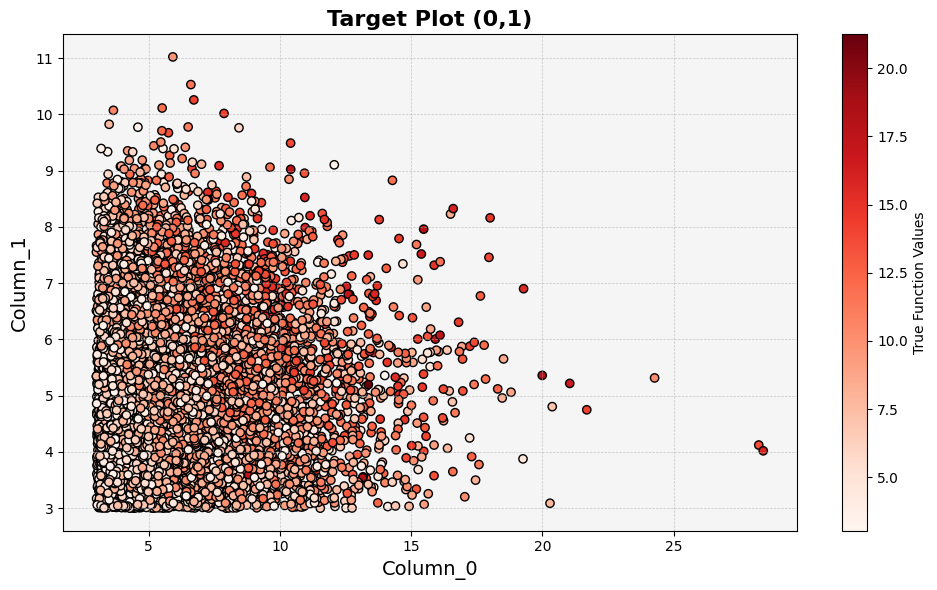

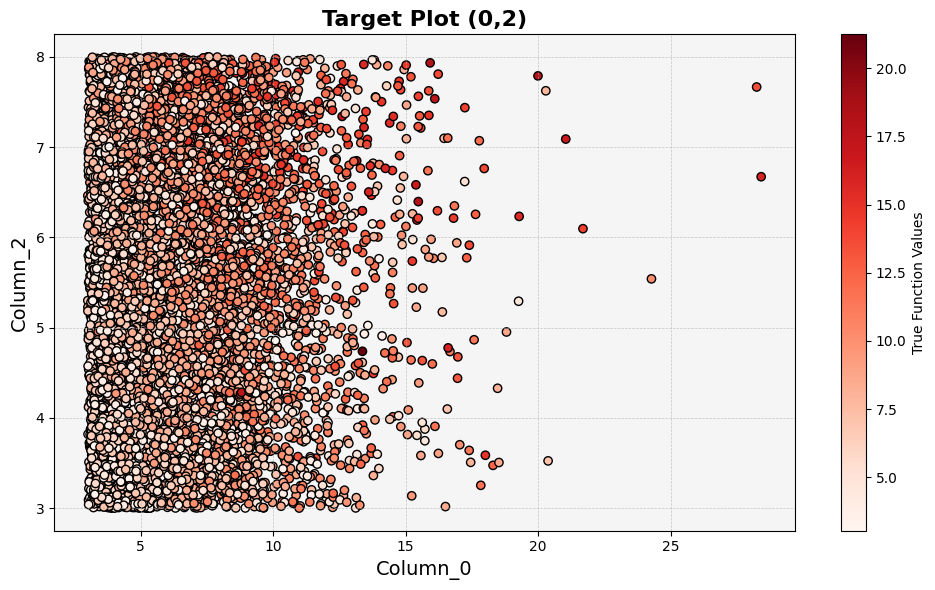

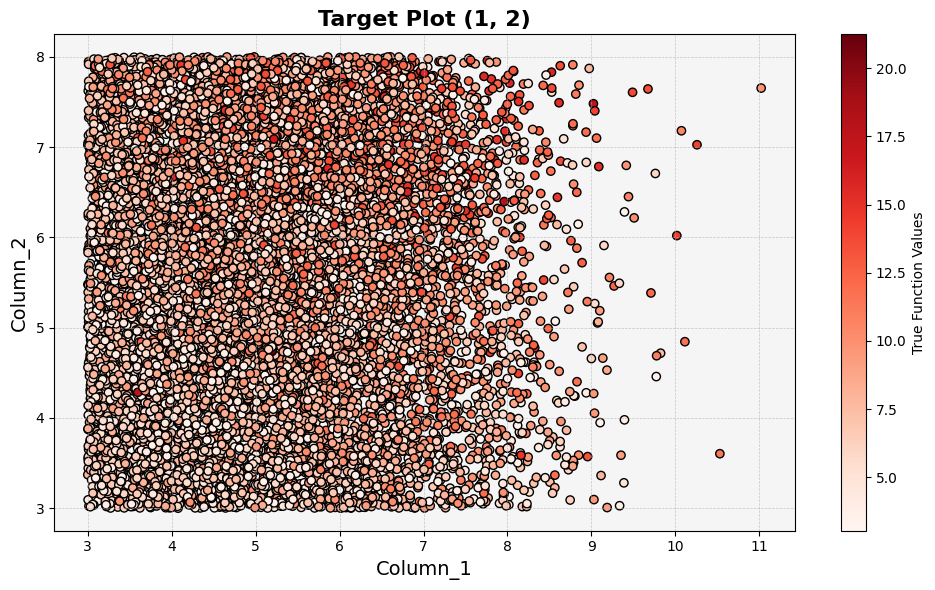

In [7]:
plot_scatter_chart(
    feature_0,
    feature_1,
    y,
    x_label="Column_0",
    y_label="Column_1",
    title="Target Plot (0,1)",
    cbar_label="True Function Values",
)

plot_scatter_chart(
    feature_0,
    feature_2,
    y,
    x_label="Column_0",
    y_label="Column_2",
    title="Target Plot (0,2)",
    cbar_label="True Function Values",
)

plot_scatter_chart(
    feature_1,
    feature_2,
    y,
    x_label="Column_1",
    y_label="Column_2",
    title="Target Plot (1, 2)",
    cbar_label="True Function Values",
)

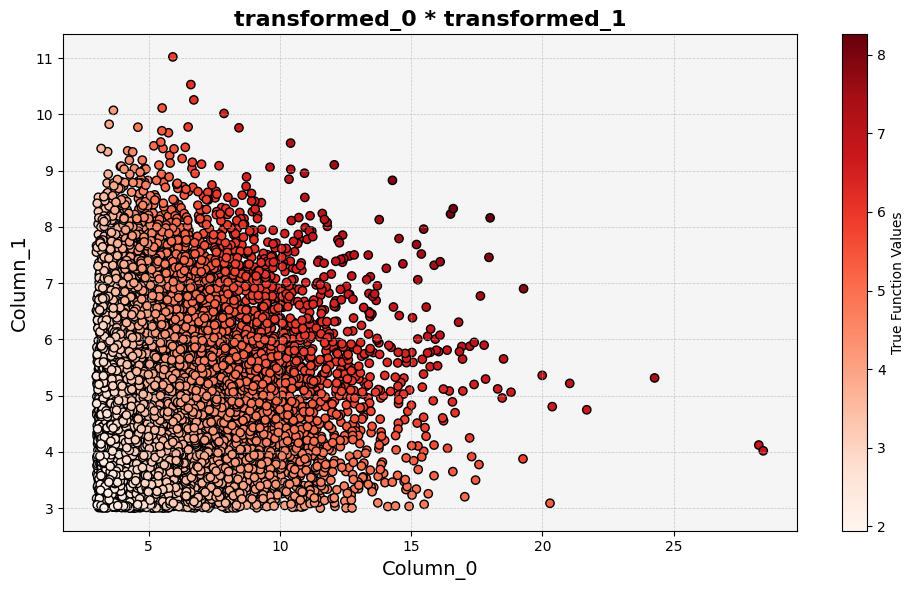

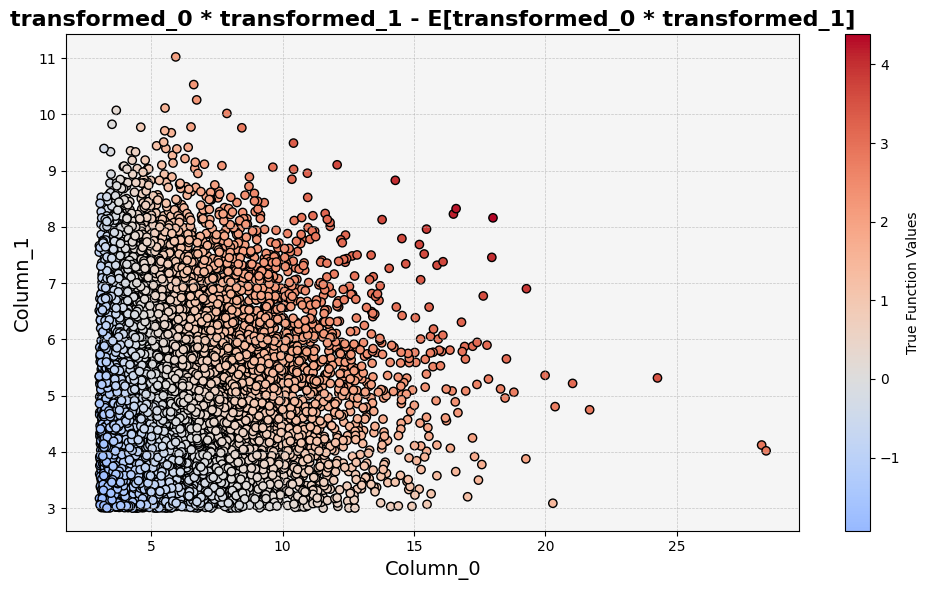

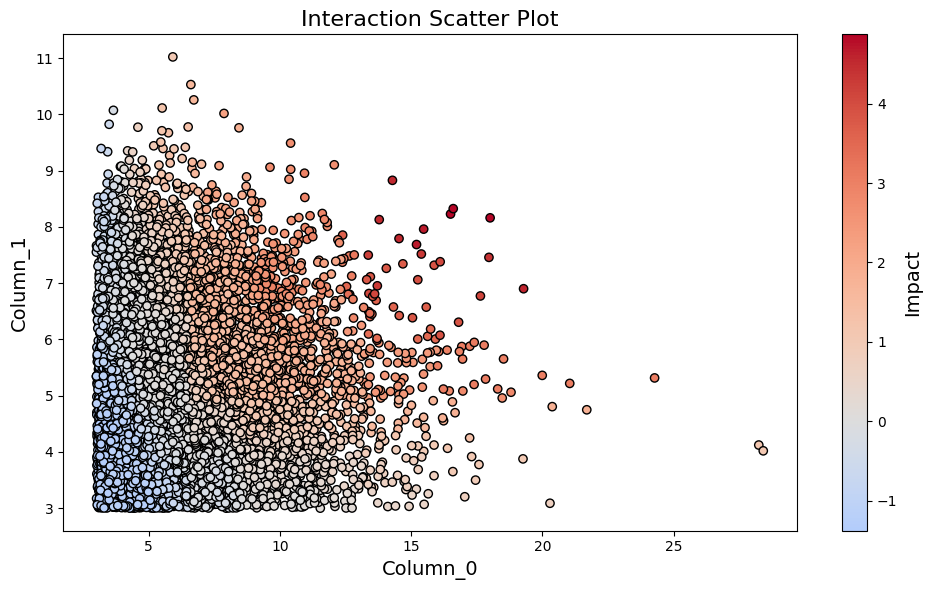

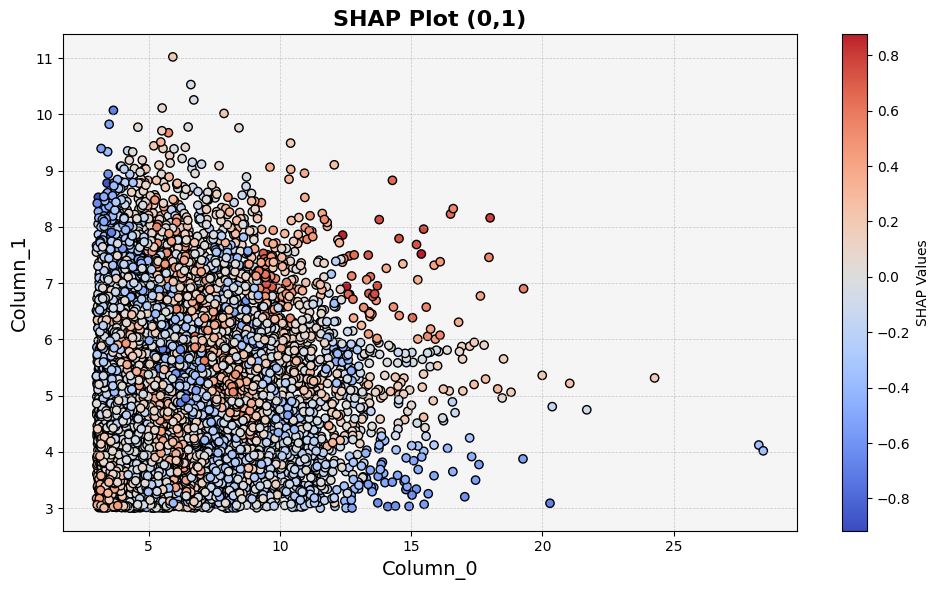

In [8]:
# Interaction Analysis: Feature 0 & Feature 1
df_01 = explainer.analyze_interaction(0, 1)
plot_scatter_chart(
    feature_0,
    feature_1,
    transformed_0 * transformed_1,
    x_label="Column_0",
    y_label="Column_1",
    title="transformed_0 * transformed_1",
    cbar_label="True Function Values",
)

plot_scatter_chart(
    feature_0,
    feature_1,
    transformed_0 * transformed_1 - np.mean(transformed_0 * transformed_1),
    x_label="Column_0",
    y_label="Column_1",
    title="transformed_0 * transformed_1 - E[transformed_0 * transformed_1]",
    cbar_label="True Function Values",
)

interaction_scatter_plot(X, df_01, 0, 1, figsize = (10,6))

plot_scatter_chart(
    feature_0,
    feature_1,
    shap_interaction_values[:, 0, 1],
    x_label="Column_0",
    y_label="Column_1",
    title="SHAP Plot (0,1)",
    cbar_label="SHAP Values",
)

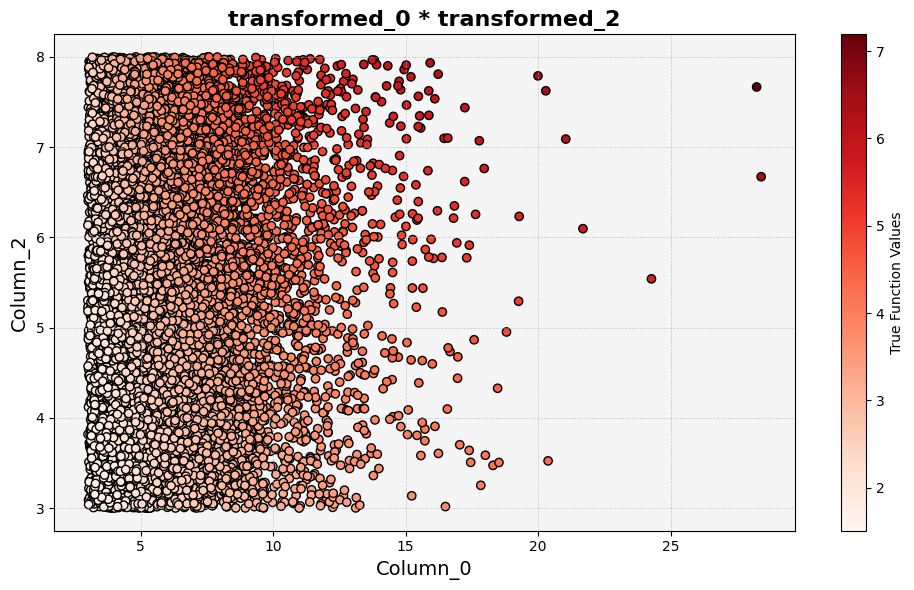

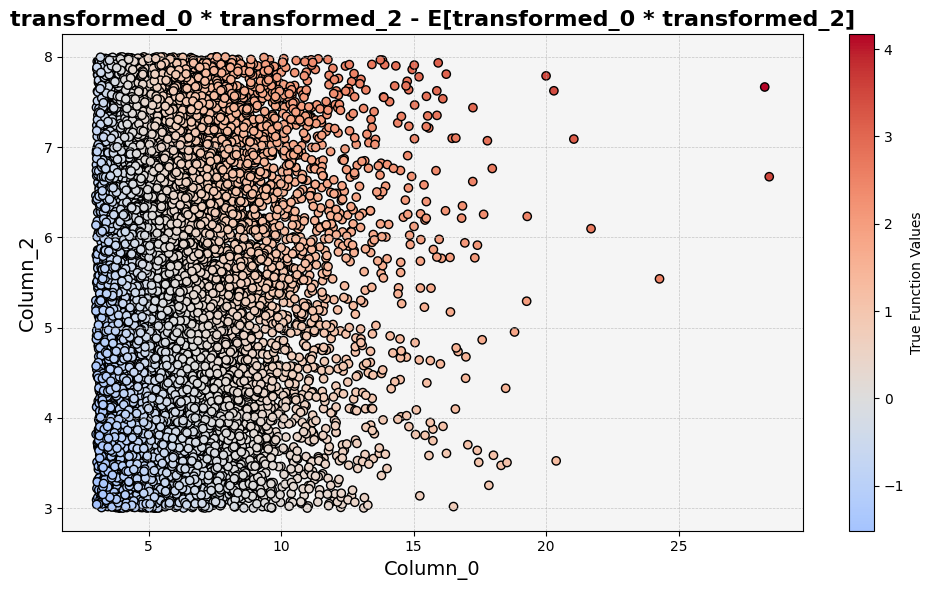

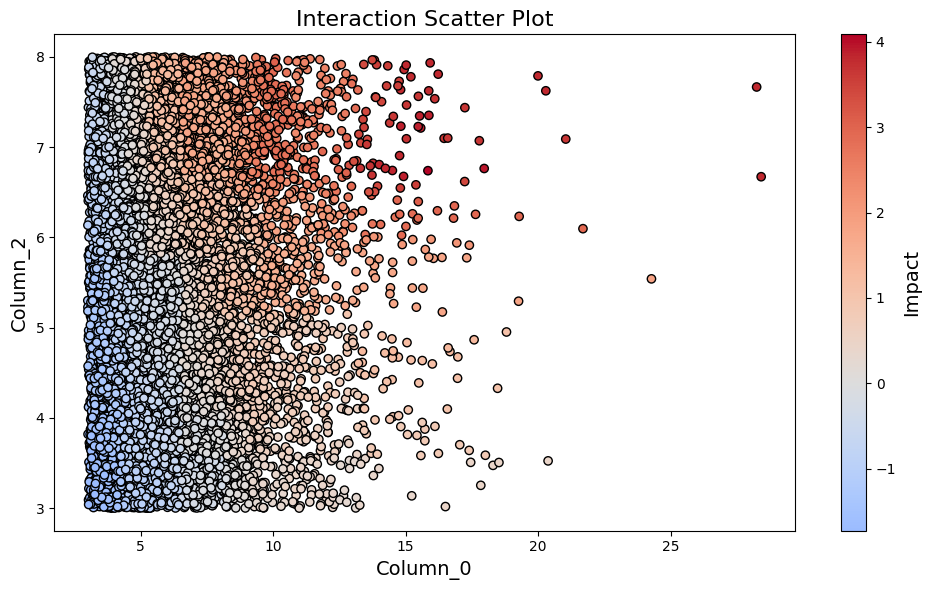

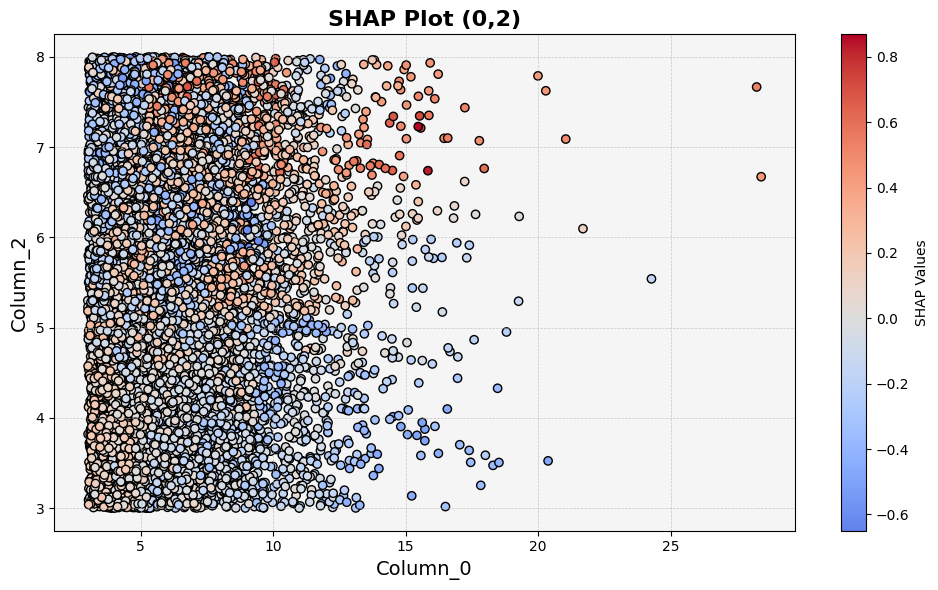

In [9]:
# Interaction Analysis: Feature 2 & Feature 3
df_02 = explainer.analyze_interaction(0, 2)

plot_scatter_chart(
    feature_0,
    feature_2,
    transformed_0 * transformed_2,
    x_label="Column_0",
    y_label="Column_2",
    title="transformed_0 * transformed_2",
    cbar_label="True Function Values",
)

plot_scatter_chart(
    feature_0,
    feature_2,
    transformed_0 * transformed_2 - np.mean(transformed_0 * transformed_2 ),
    x_label="Column_0",
    y_label="Column_2",
    title="transformed_0 * transformed_2 - E[transformed_0 * transformed_2]",
    cbar_label="True Function Values",
)

interaction_scatter_plot(X, df_02, 0, 2,  figsize = (10,6))

plot_scatter_chart(
    feature_0,
    feature_2,
    shap_interaction_values[:, 0, 2],
    x_label="Column_0",
    y_label="Column_2",
    title="SHAP Plot (0,2)",
    cbar_label="SHAP Values",
)

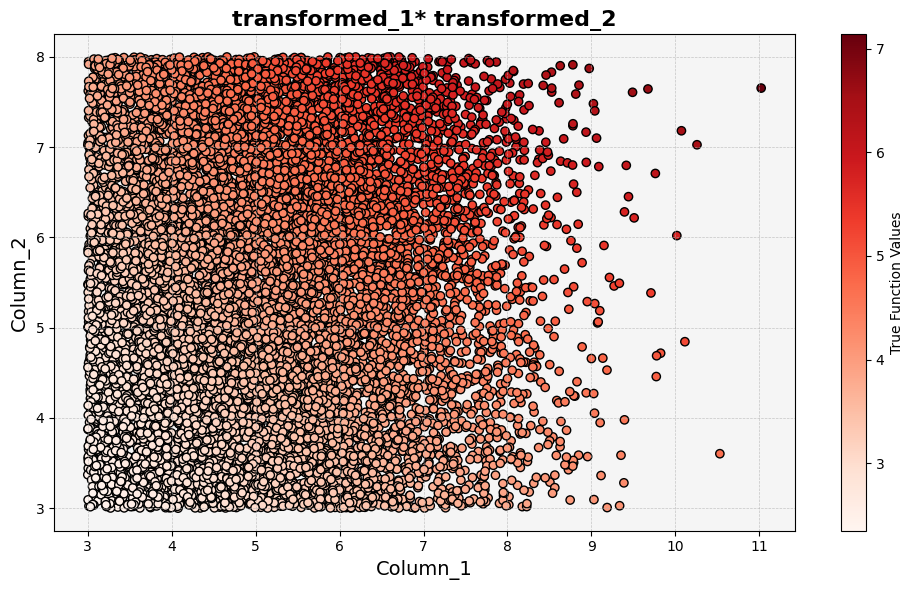

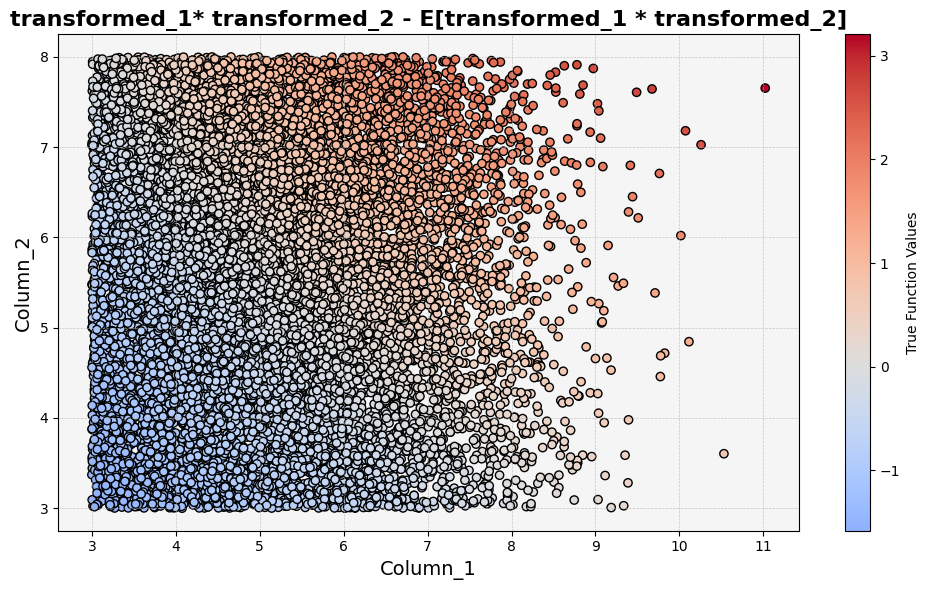

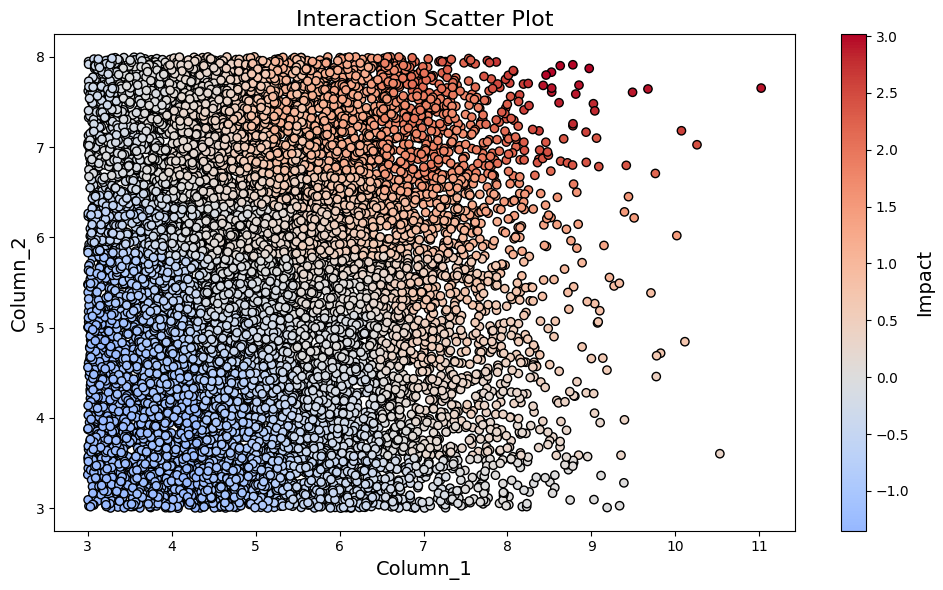

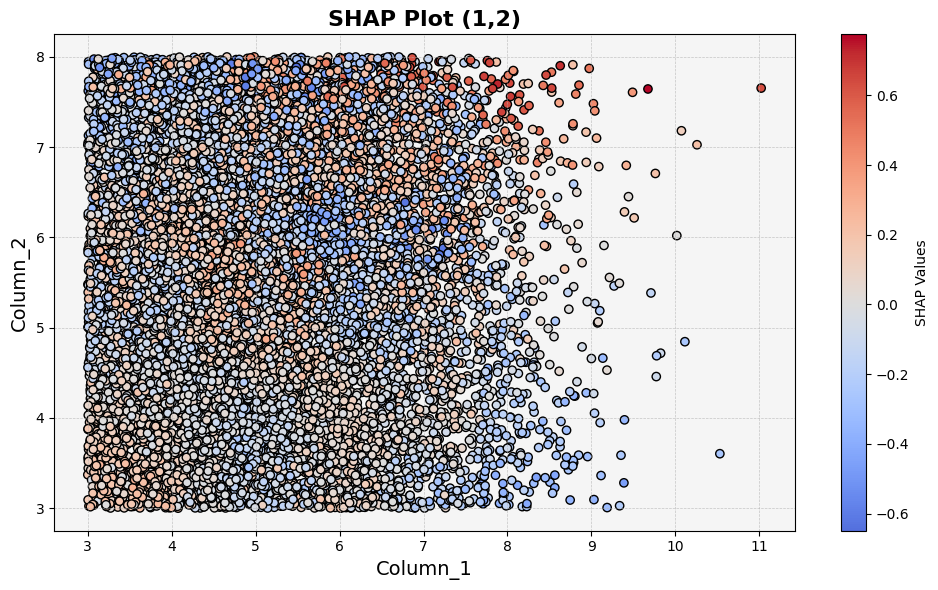

In [10]:
# Interaction Analysis: Feature 2 & Feature 3
df_02 = explainer.analyze_interaction(1, 2)

plot_scatter_chart(
    feature_1,
    feature_2,
    transformed_1 * transformed_2,
    x_label="Column_1",
    y_label="Column_2",
    title="transformed_1* transformed_2",
    cbar_label="True Function Values",
)


plot_scatter_chart(
    feature_1,
    feature_2,
    transformed_1 * transformed_2 - np.mean(transformed_1 * transformed_2 ),
    x_label="Column_1",
    y_label="Column_2",
    title="transformed_1* transformed_2 - E[transformed_1 * transformed_2]",
    cbar_label="True Function Values",
)


interaction_scatter_plot(X, df_02, 1, 2,  figsize = (10,6))

plot_scatter_chart(
    feature_1,
    feature_2,
    shap_interaction_values[:, 1, 2],
    x_label="Column_1",
    y_label="Column_2",
    title="SHAP Plot (1,2)",
    cbar_label="SHAP Values",
)